Compiling all files...
Compiling all files...


C:\Users\Catherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Catherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Catherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

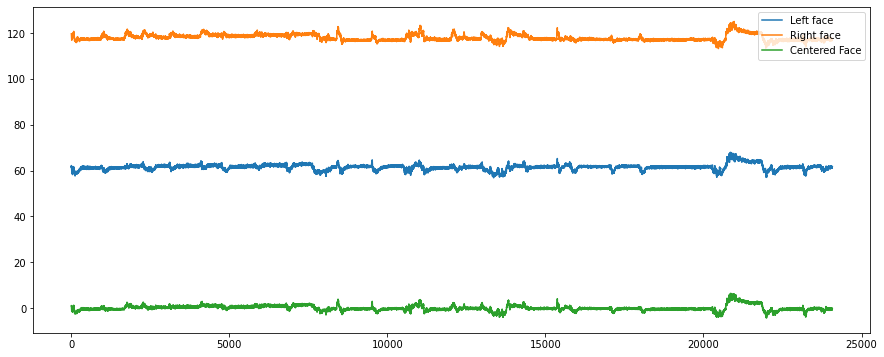

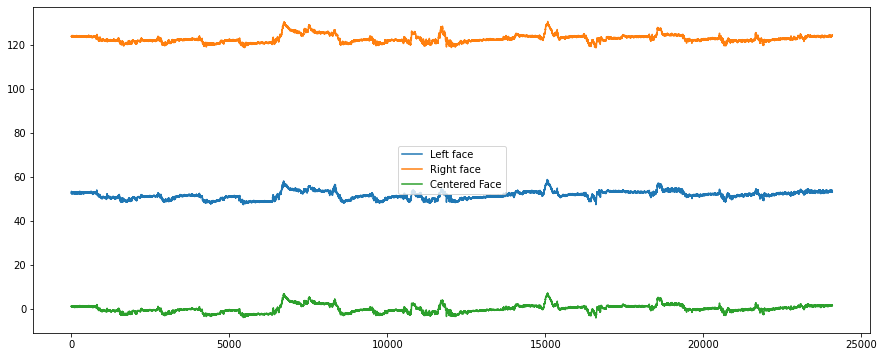

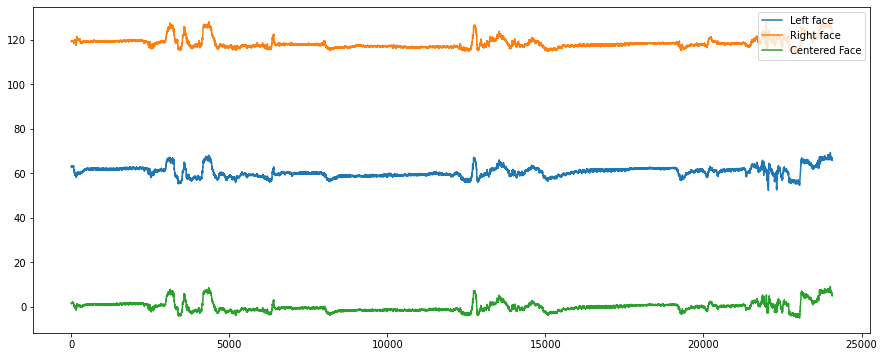

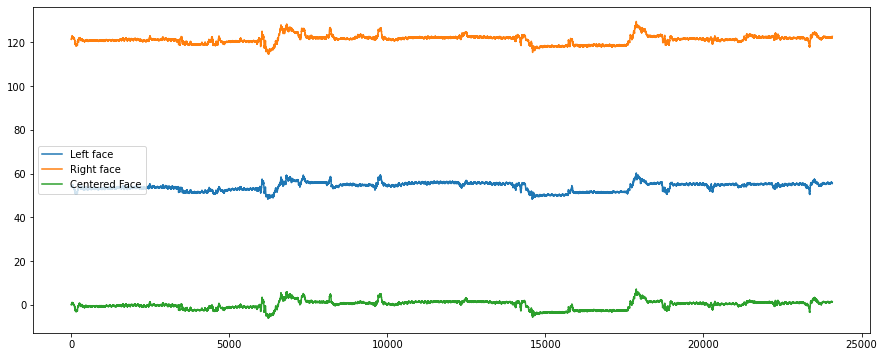

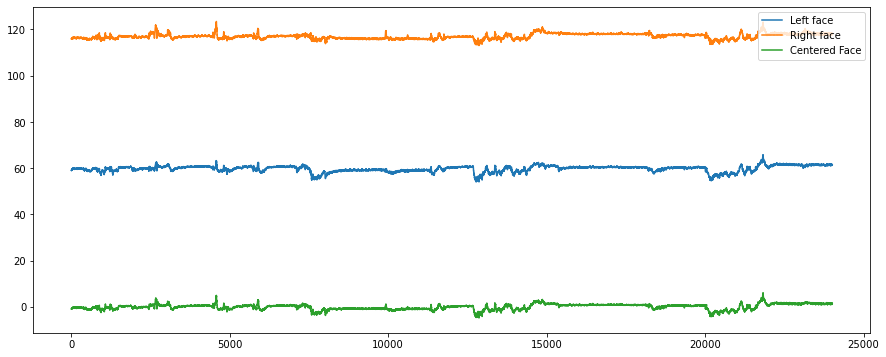

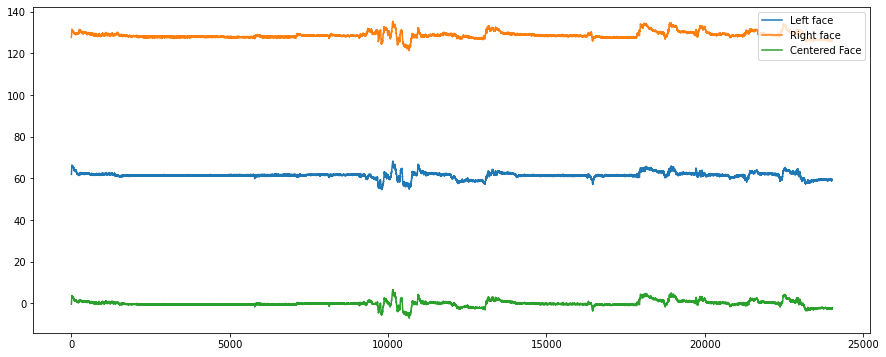

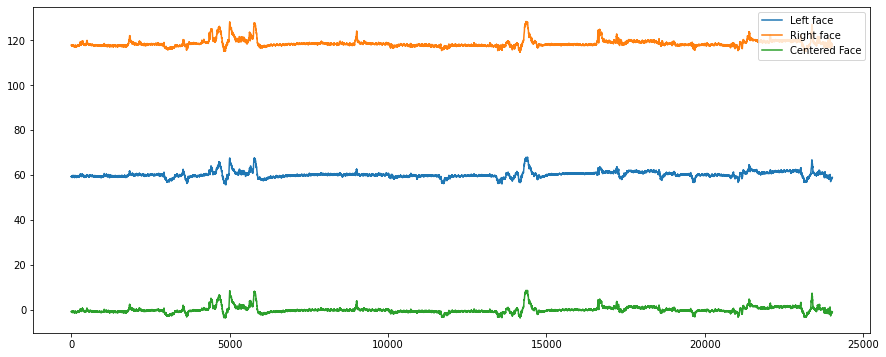

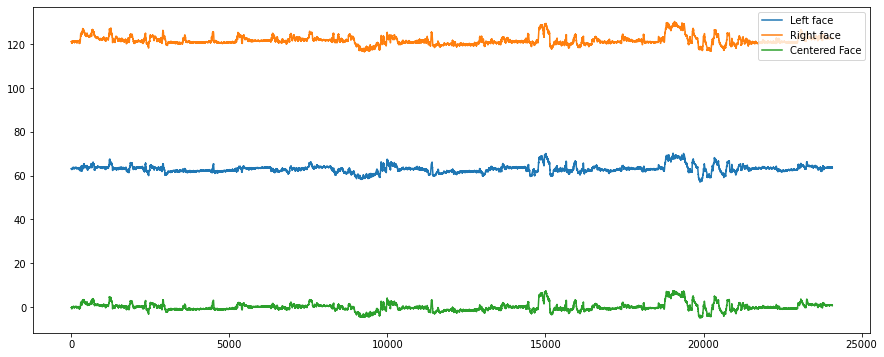

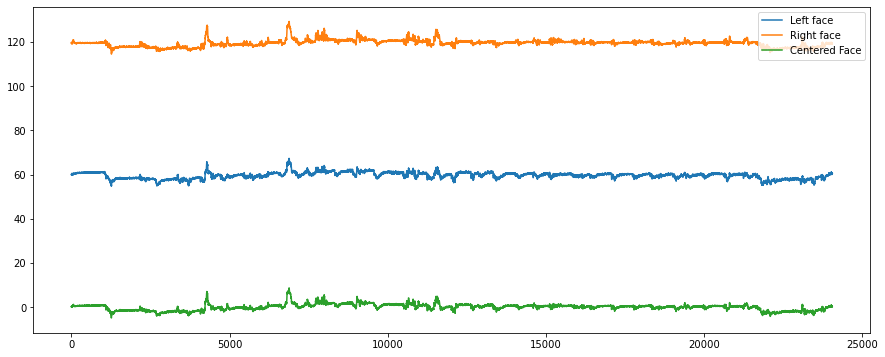

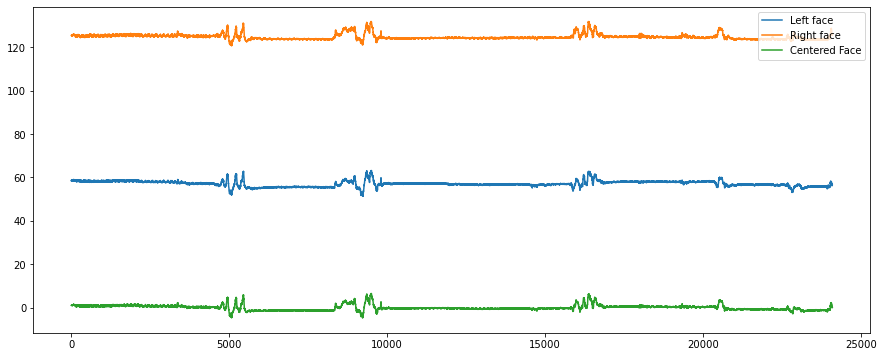

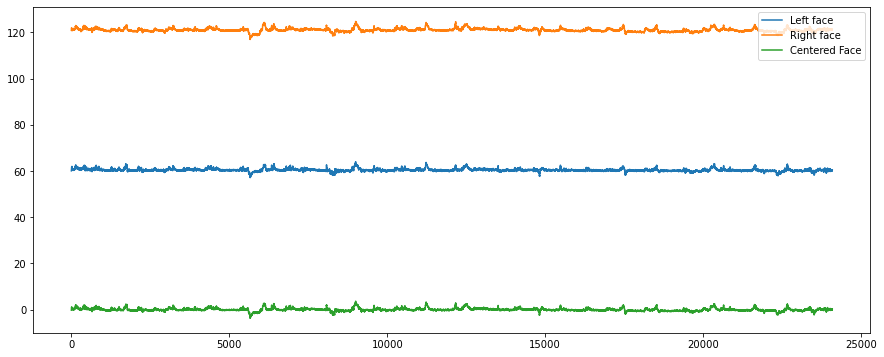

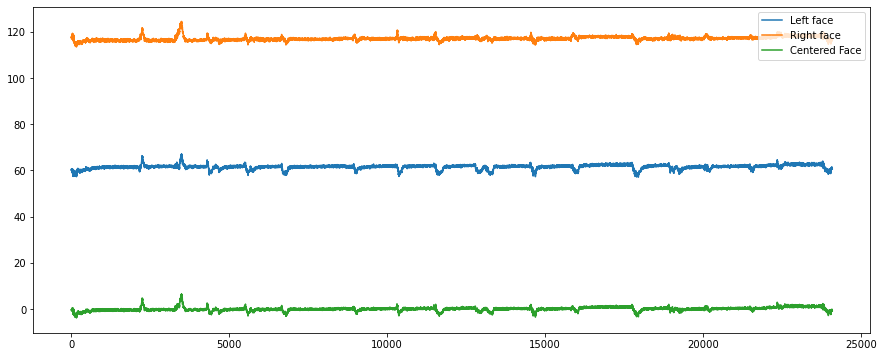

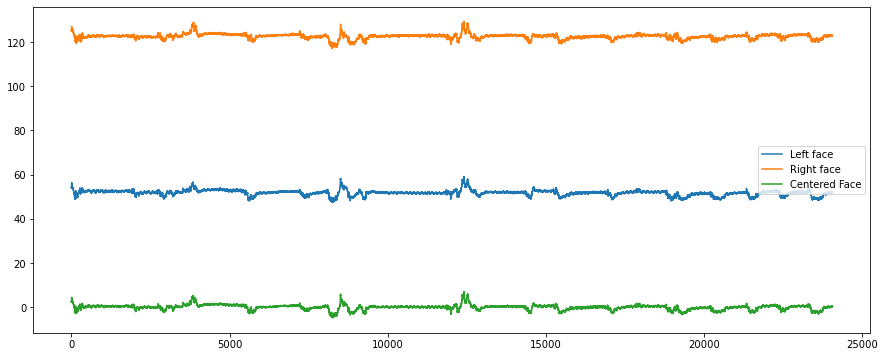

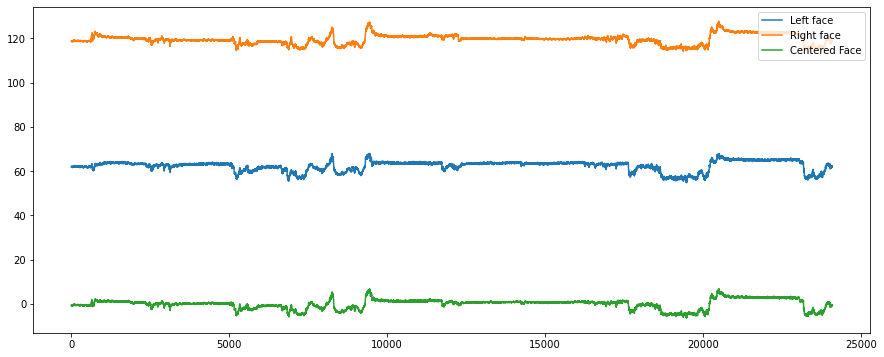

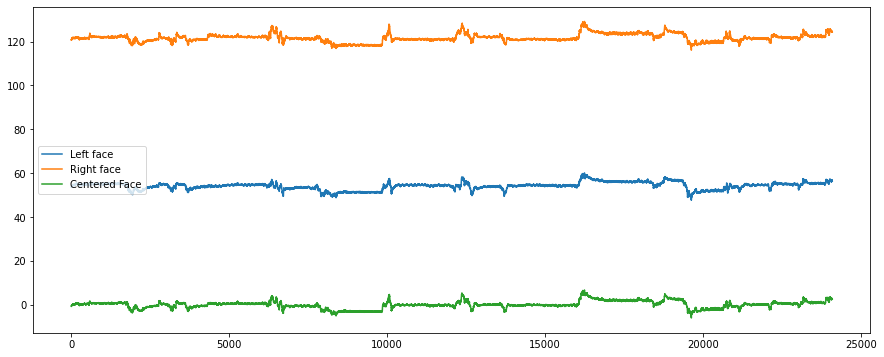

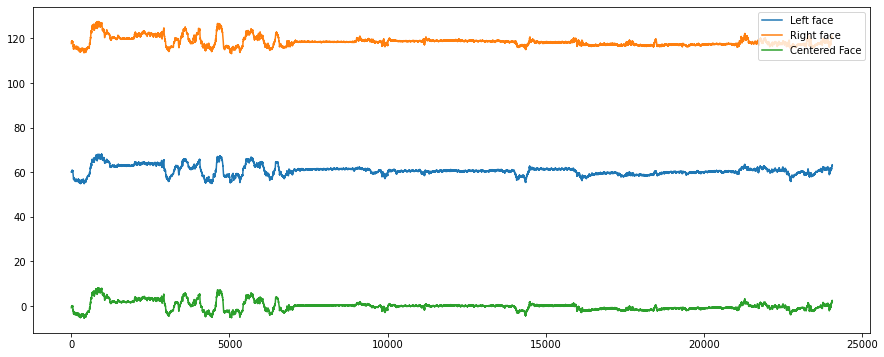

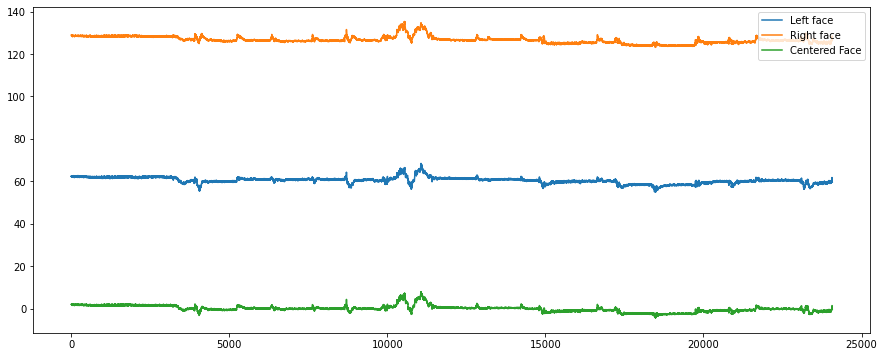

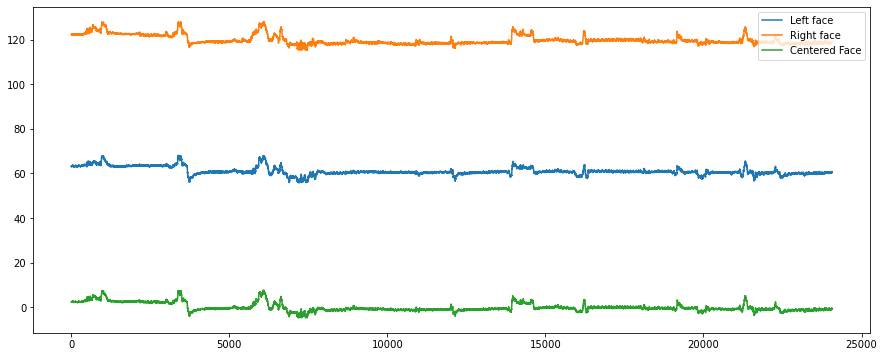

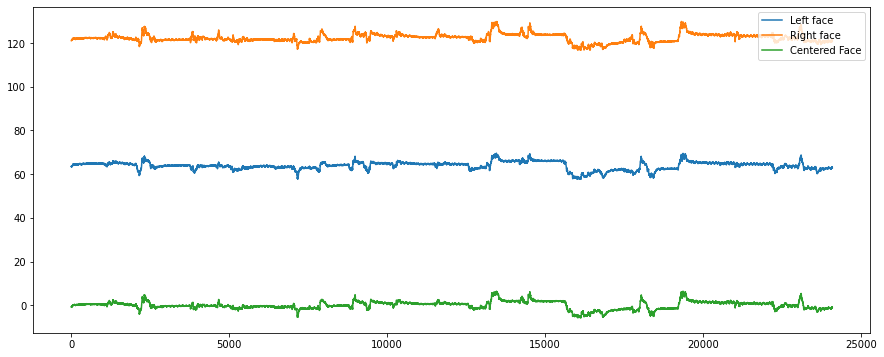

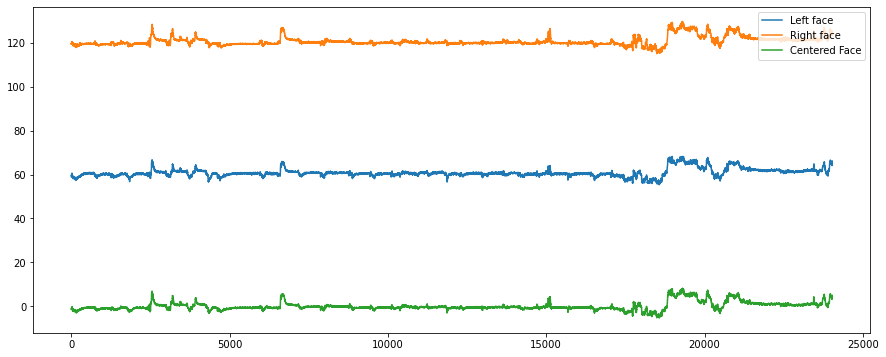

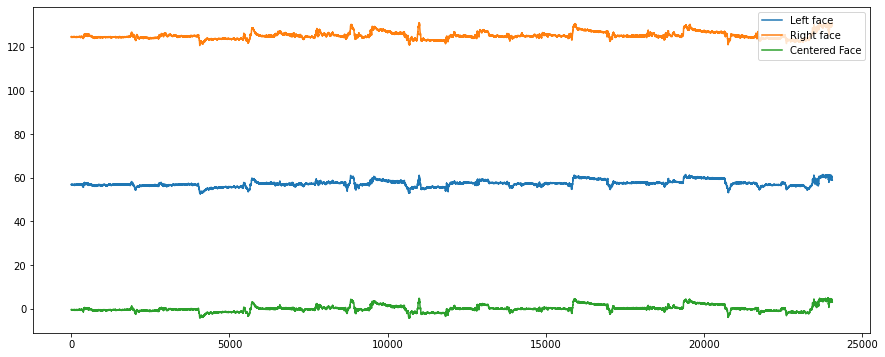

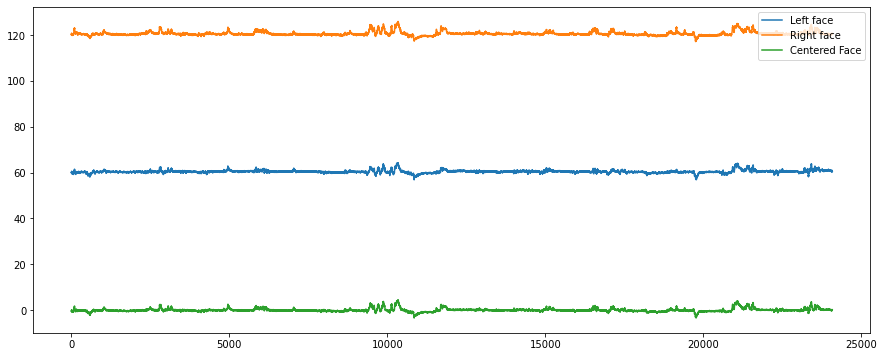

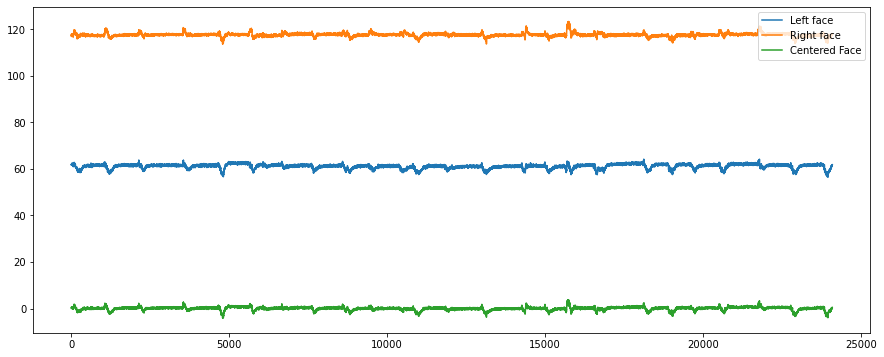

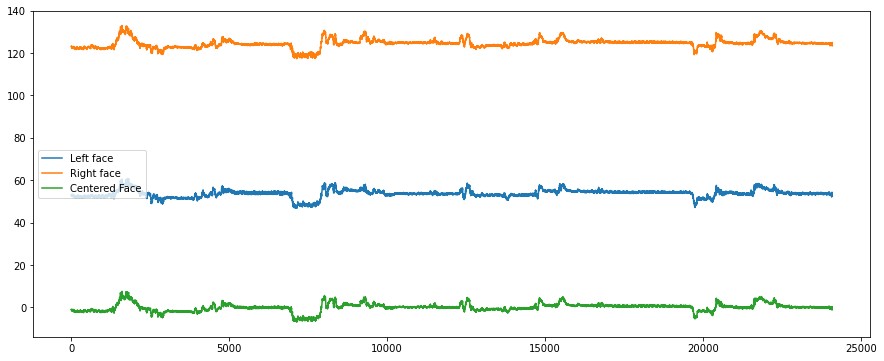

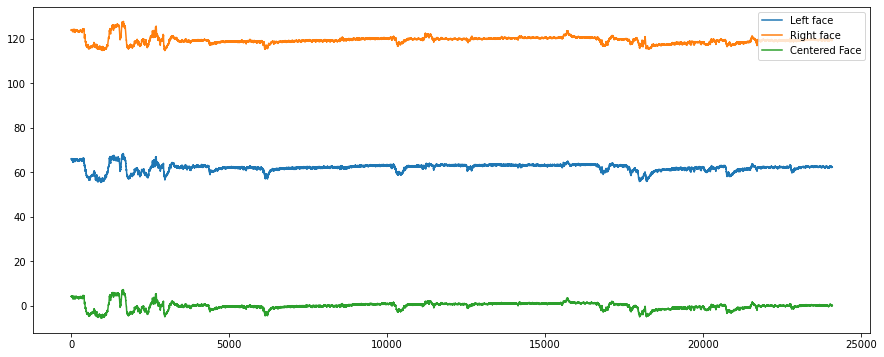

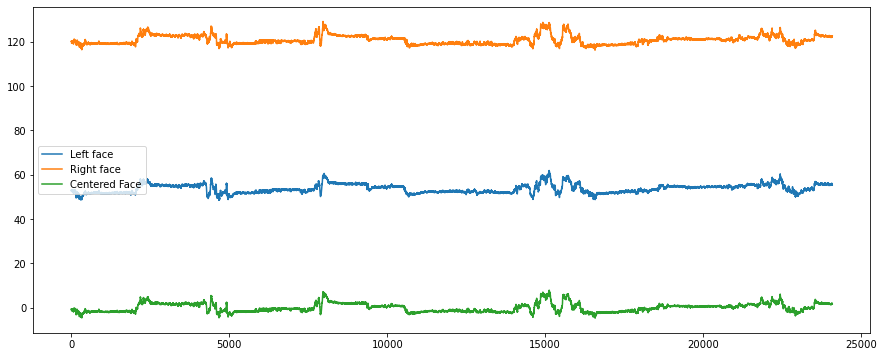

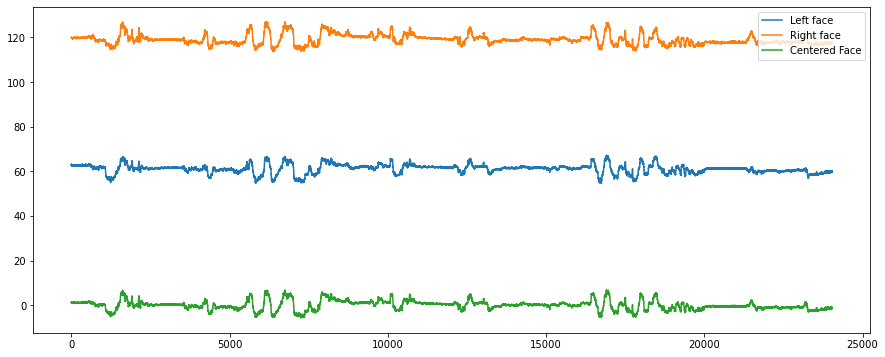

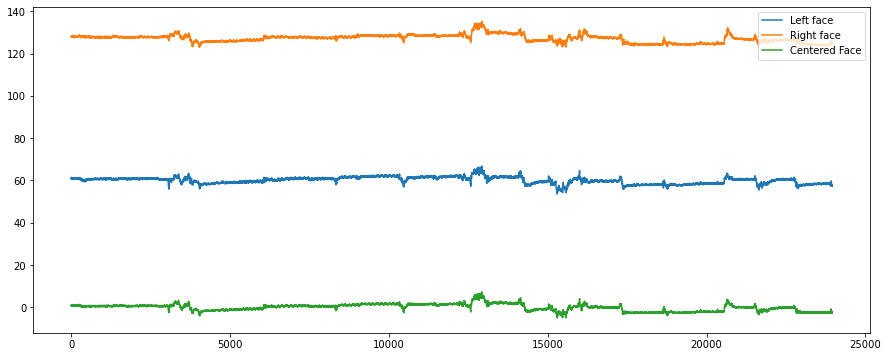

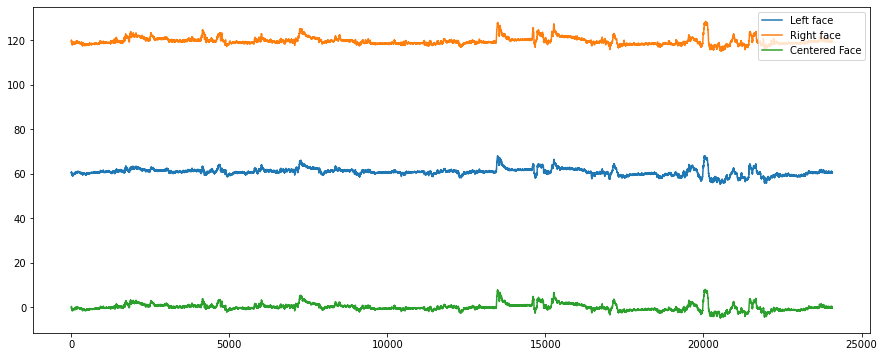

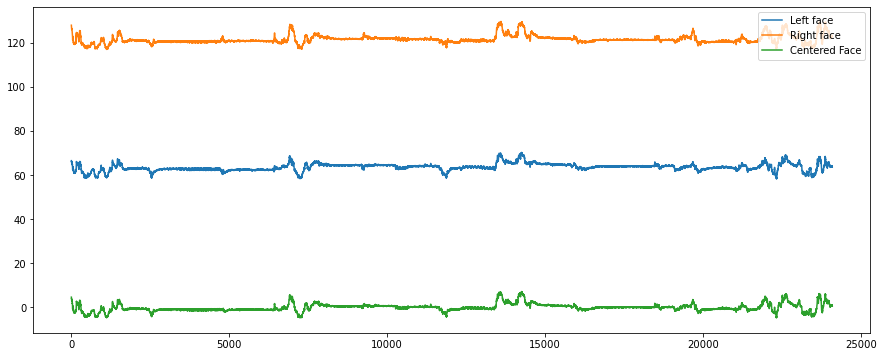

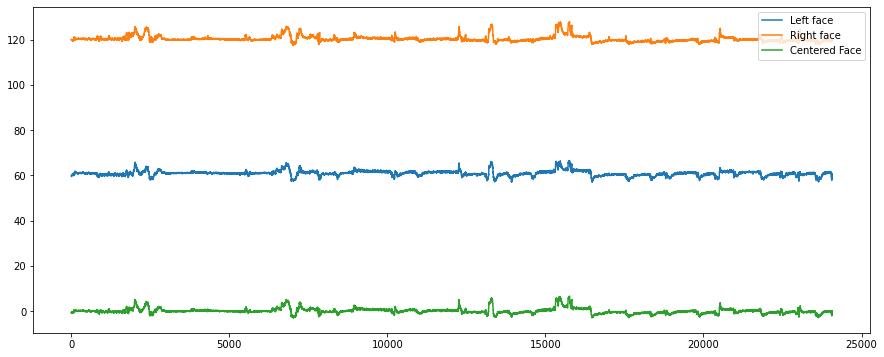

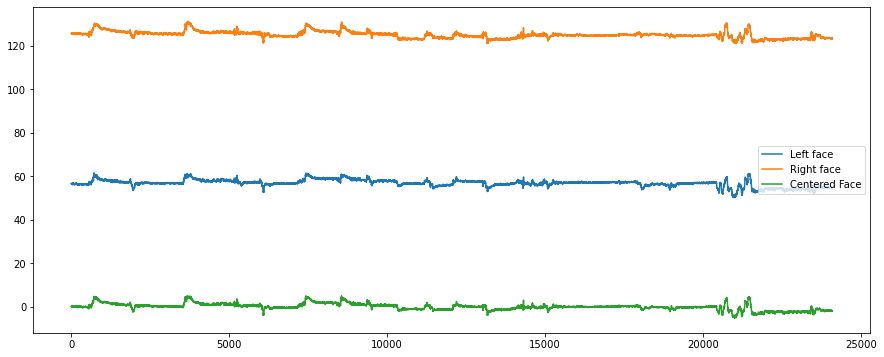

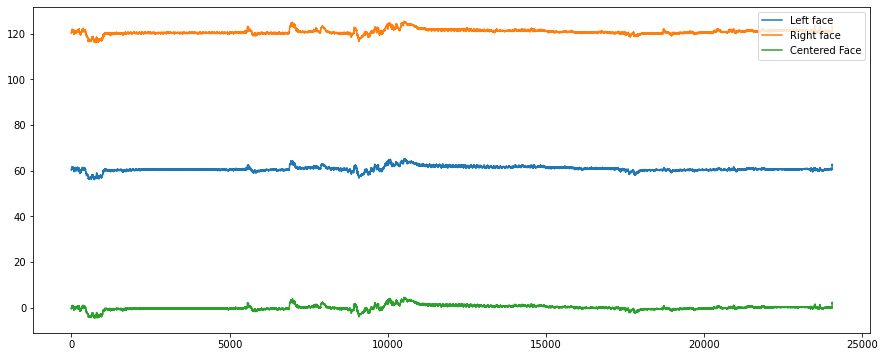

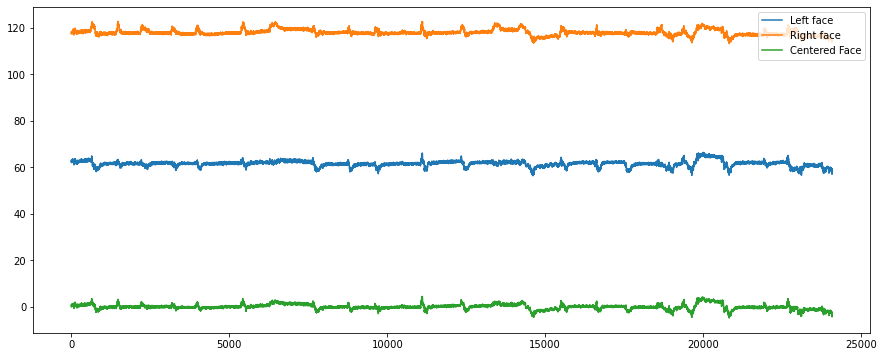

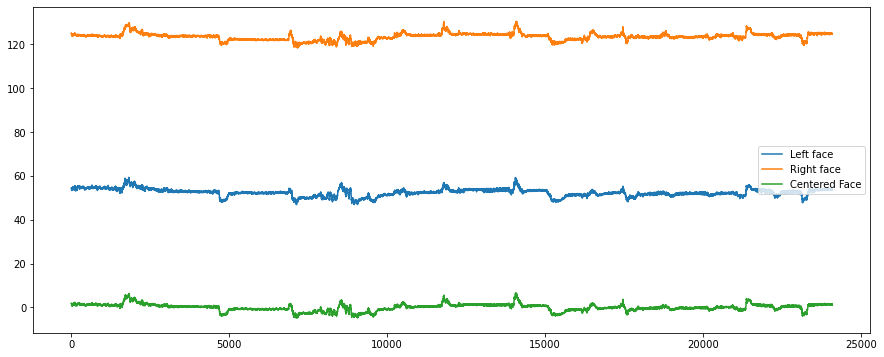

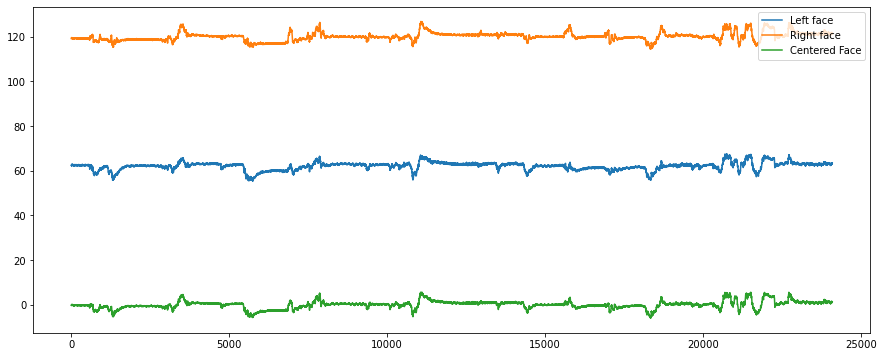

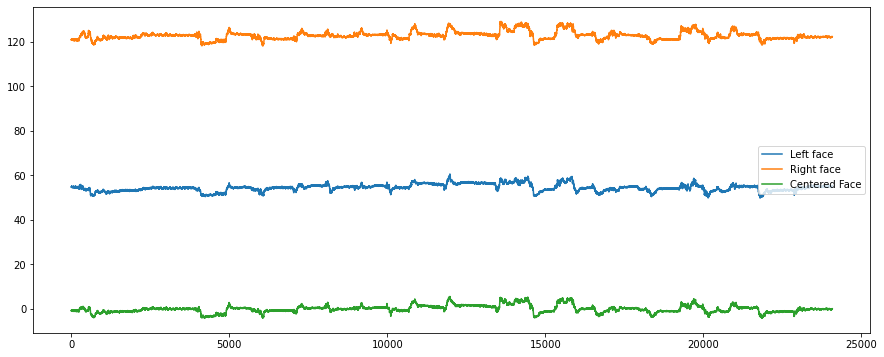

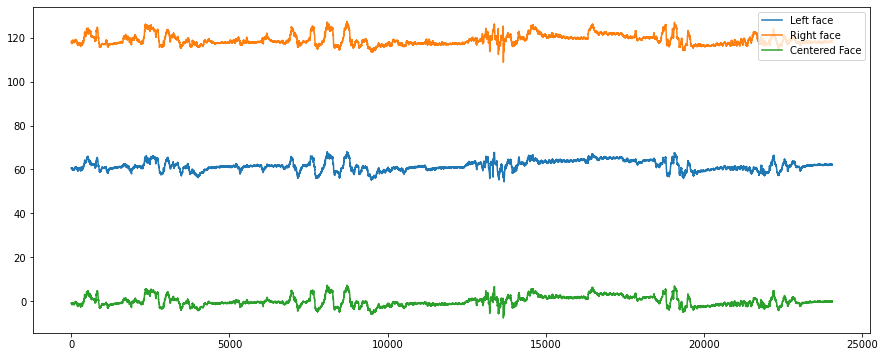

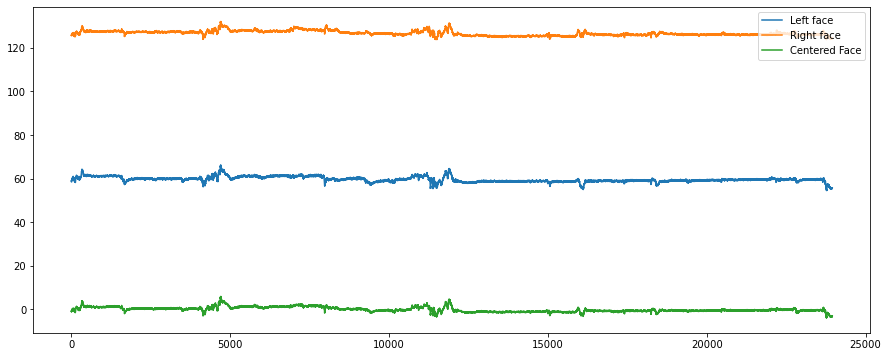

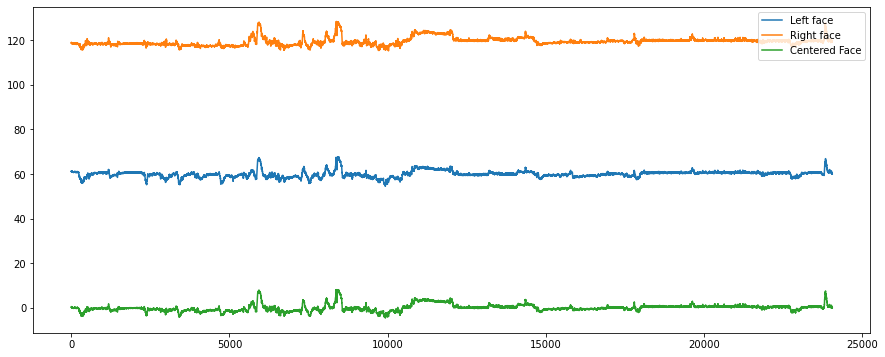

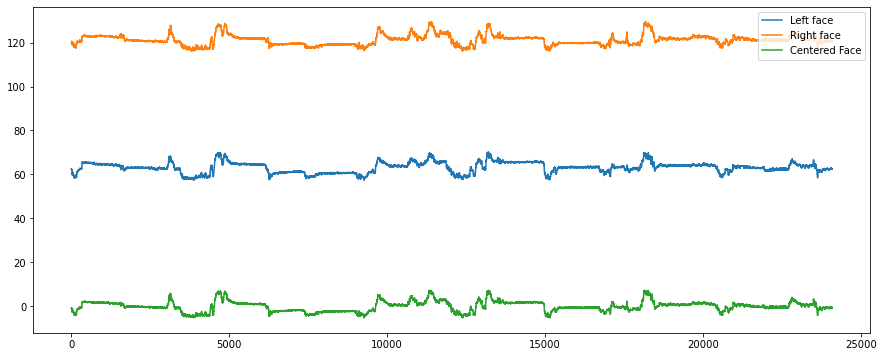

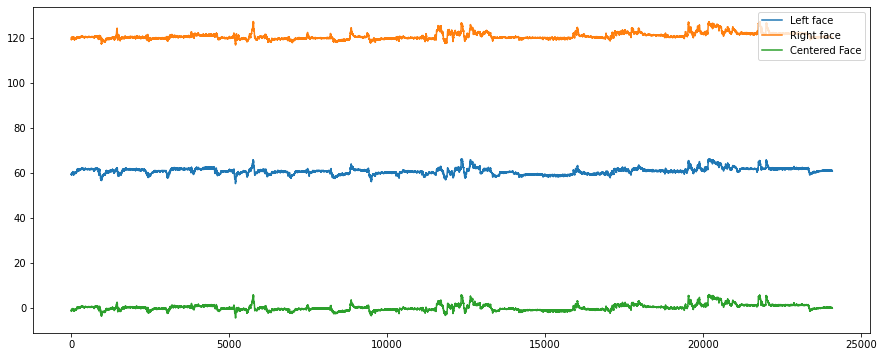

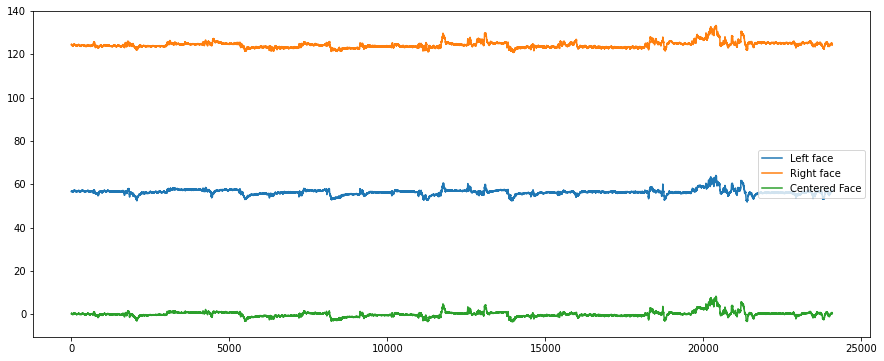

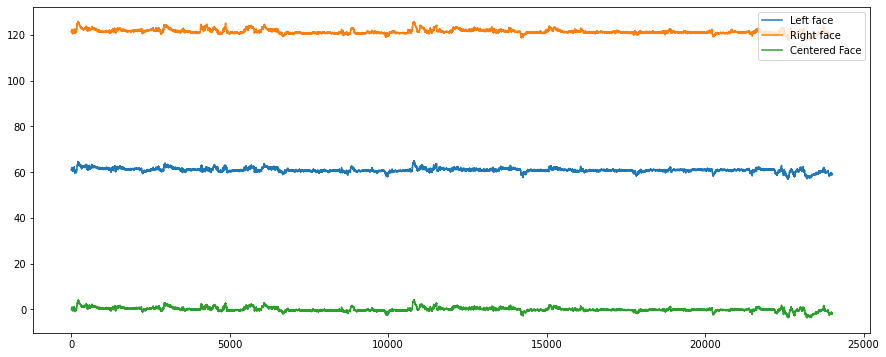

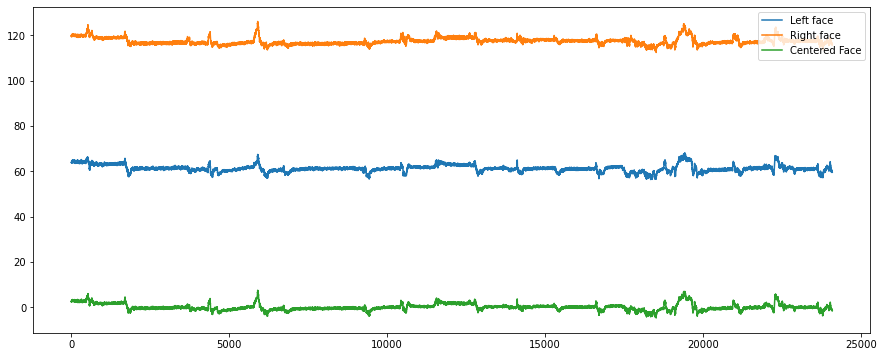

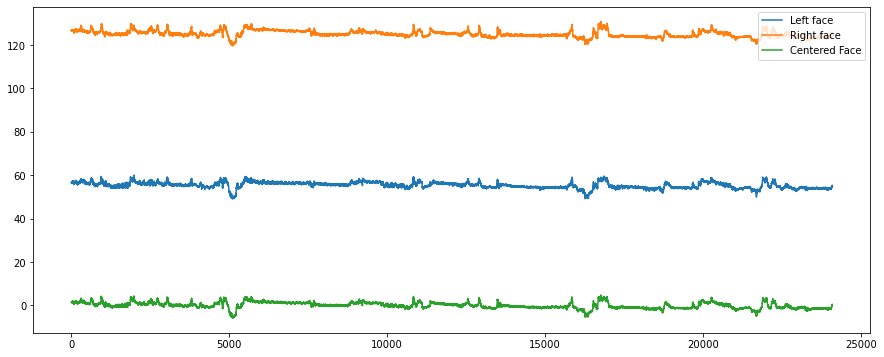

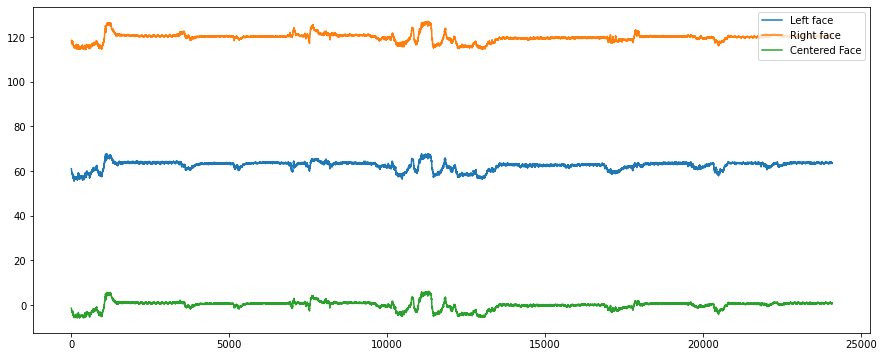

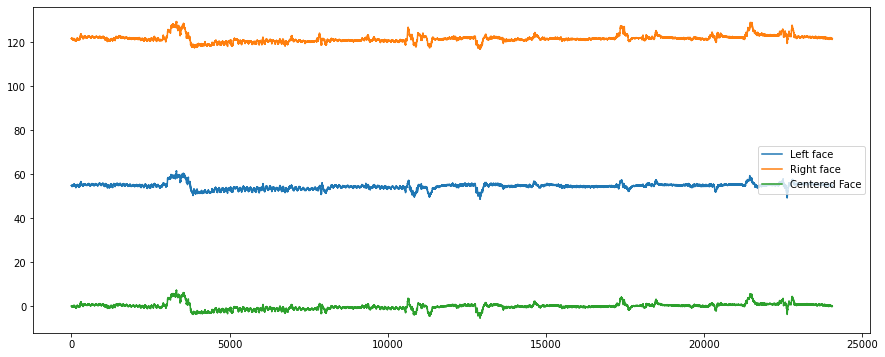

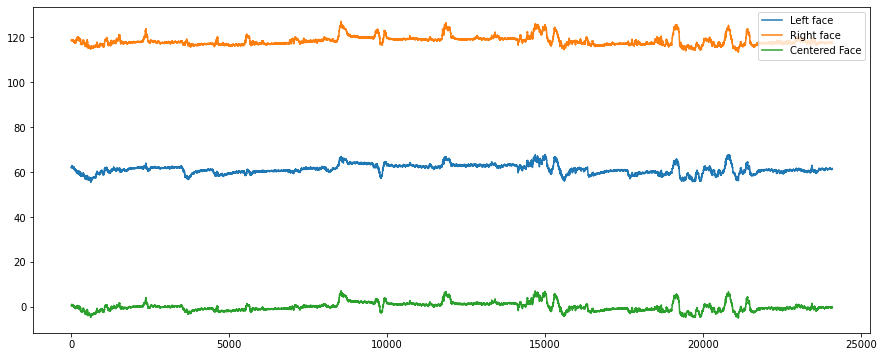

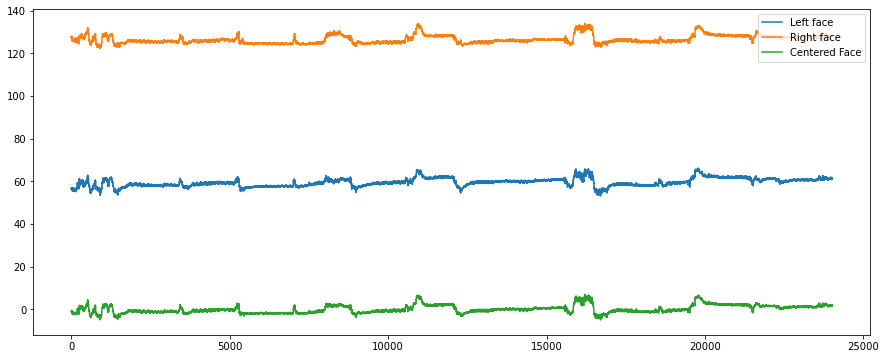

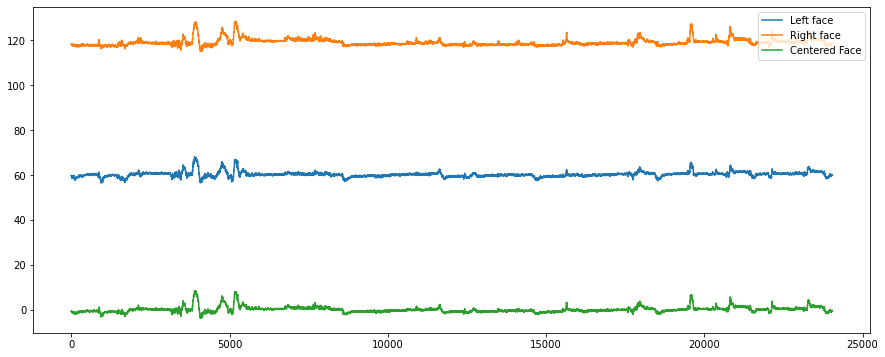

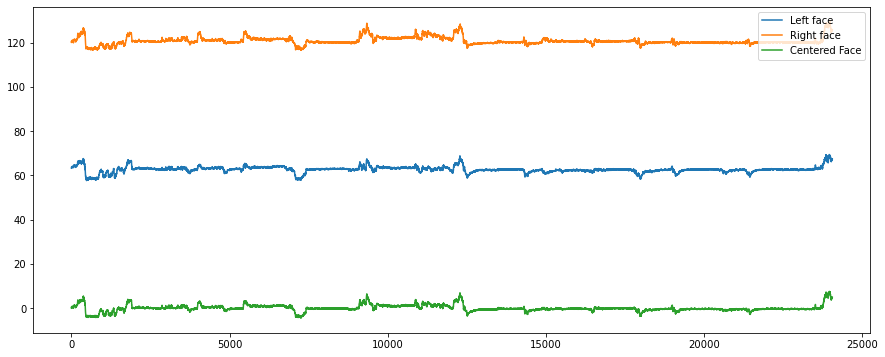

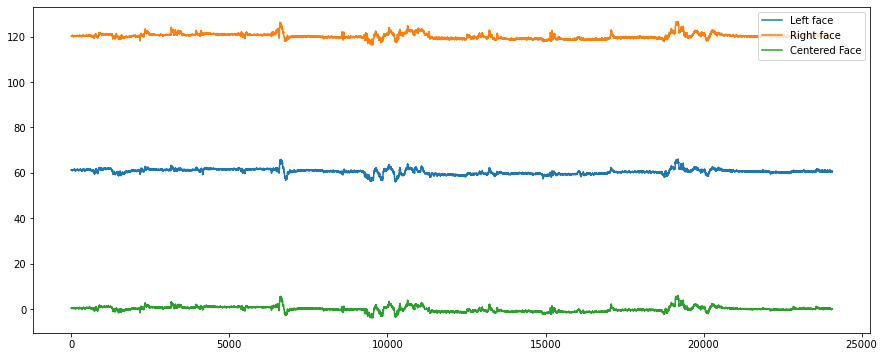

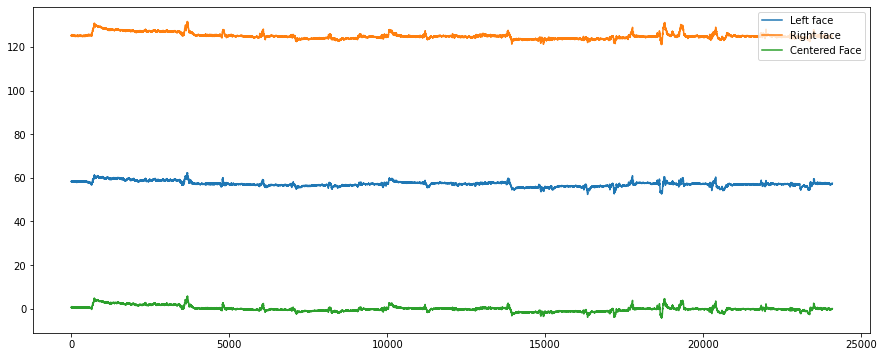

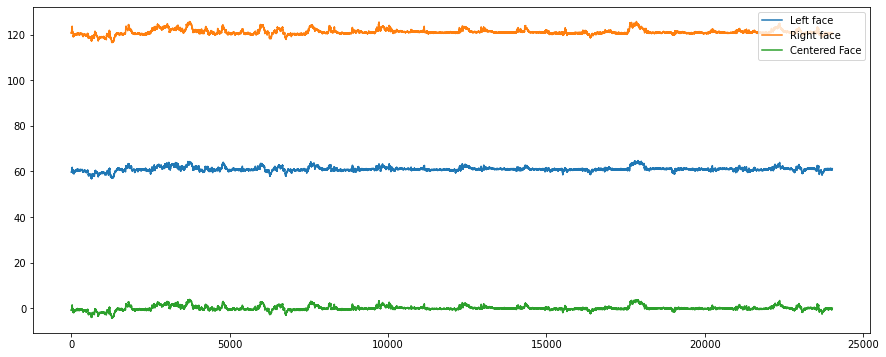

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import glob as glob

lesion = []
control = []
path = "lesion-Anna-2019-11-24/"
datelist = ["videos"] # get the folder name
all_files = list()
print('Compiling all files...')
for dates in datelist:
    for file in glob.glob(path + dates + "/*.csv"):
        lesion.append(file)

path = "control-Anna-2019-12-12/"
datelist = ["videos"] # get the folder name
all_files = list()
print('Compiling all files...')
for dates in datelist:
    for file in glob.glob(path + dates + "/*.csv"):
        control.append(file)
        
for path in control:
    # Read in data from DeepLabCut with pandas
    csv_path = path
    file = pd.read_csv(csv_path,
                      header=[1,2]).astype(float)

    data = pd.DataFrame(file)
    # print(data)

    # Calculate face angles
    data['Face','LeftSide']  = np.arctan2(-1.*(data['LeftEye']['y']  - data['Nose']['y']), data['LeftEye']['x']  - data['Nose']['x'])*180./np.pi
    data['Face','RightSide'] = np.arctan2(-1.*(data['RightEye']['y'] - data['Nose']['y']), data['RightEye']['x'] - data['Nose']['x'])*180./np.pi

    # Filter face angles
    filter_faces = True
    f_cut = 30 # cutoff freq.
    order = 5 # Use 5th order low pass butterworth filter
    f_samp = 400 # sampling freq. (frames per second)

    if filter_faces:
        f_nyq = f_samp / 2 # Nyquist freq.
        f_norm = f_cut / f_nyq # Normalize the frequency
        b, a = signal.butter(order, f_norm, btype='lowpass')

        data['Face']['LeftSide']  = signal.filtfilt(b, a, data['Face']['LeftSide'])
        data['Face']['RightSide'] = signal.filtfilt(b, a, data['Face']['RightSide'])

    # Calculate angle mouse is looking (centered on zero)
    mu = np.mean(data['Face'][['LeftSide', 'RightSide']].mean()[:])
    data['Face','Angle'] = data['Face'][['LeftSide', 'RightSide']].mean(axis=1) - mu

    # Calculate derivative of face angle
    data['Face', 'd/dt'] = abs(np.gradient(data['Face','Angle'], 1/f_samp))

    # Calculate face angle likelihood (avg of components)
    data['Face', 'likelihood'] =   (data['LeftEye','likelihood'] +
                                    data['RightEye','likelihood'] +
                                    data['Nose','likelihood'])/3

    # Plot face angle results
    plt.figure(figsize=(15,6))
    plt.plot(data['Face']['LeftSide'])
    plt.plot(data['Face']['RightSide'])
    plt.plot(data['Face']['Angle'])
    # plt.plot(data['Face']['d/dt'], alpha = 0.3)
    plt.legend(['Left face', 'Right face','Centered Face', 'd/dt'])
    
    """
    This cell processes eah whisker for:
        1. azimuthal angle
        2. d/dt of azimuthal angle
        3. Likehood of azimuthal angle
    """
    # Process each whisker
    whiskers = ['L1', 'L2', 'L3', 'R1', 'R2', 'R3']
    for whisker in whiskers:
        # Calculate azimuthal angle of all whiskers
        data[whisker, 'Angle'] = calc_azimuthal_angle(whisker, normalize=False)
        # Calculate derivative of whisker angles
        data[whisker, 'd/dt'] = abs(np.gradient(data[whisker,'Angle'], 1/f_samp))

        # Calculate likelihood of whisker angles (avg of detections)
        data[whisker, 'likelihood'] =  (data[whisker+'-1','likelihood'] +
                                        data[whisker+'-2','likelihood'] +
                                        data[whisker+'-3','likelihood'] +
                                        data[whisker+'-4','likelihood'])/4

    # print(data)
        """
    This cell writes the calculated data out
    into a .csv file
    """
    # new = old[['A', 'C', 'D']].copy()
    data_out = data[['Face','L1', 'L2', 'L3', 'R1', 'R2', 'R3']]
    data_out = data_out.drop([('Face','LeftSide'), ('Face','RightSide')], axis=1)

    angles_csv_path = '/'.join(csv_path.split('/')[:-1]) + '/videos/angles/' + csv_path.split('\\')[-1]
    angles_csv_path = '-'.join(angles_csv_path.split('-')[:-1])+'-angles.csv'
    outdir = '/'.join(angles_csv_path.split('/')[:-1])

    # Make 'angles/' directory if doesn't exist
    import os
    if not os.path.exists(outdir):
        os.mkdir(outdir)

    # print(data_out)
    cols = []
    for col in data_out.columns:
        cols.append(('DeepLabCut_angles',)+col)
    # print(cols)
    # data_out = pd.concat([data_out], keys=['Foo'], names=['Firstlevel'])
    data_out.columns = pd.MultiIndex.from_tuples(cols)
    # print(data_out)

    data_out.to_csv(angles_csv_path)

    
    

C:\Users\Catherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Catherine\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


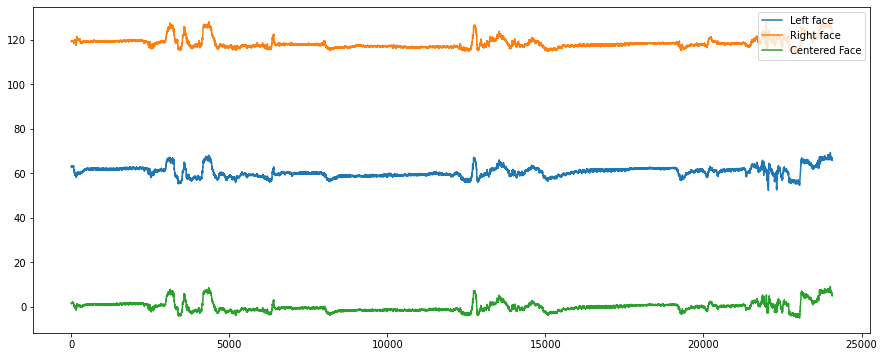

In [6]:
csv_path = 'control-Anna-2019-12-12/videos/1-12102019183236-0000DeepCut_resnet50_controlDec12shuffle1_200000.csv'
file = pd.read_csv(csv_path, header=[1,2]).astype(float)
data = pd.DataFrame(file)

# Calculate face angles
data['Face','LeftSide']  = np.arctan2(-1.*(data['LeftEye']['y']  - data['Nose']['y']), data['LeftEye']['x']  - data['Nose']['x'])*180./np.pi
data['Face','RightSide'] = np.arctan2(-1.*(data['RightEye']['y'] - data['Nose']['y']), data['RightEye']['x'] - data['Nose']['x'])*180./np.pi

# Filter face angles
filter_faces = True
f_cut = 30 # cutoff freq.
order = 5 # Use 5th order low pass butterworth filter
f_samp = 400 # sampling freq. (frames per second)

if filter_faces:
    f_nyq = f_samp / 2 # Nyquist freq.
    f_norm = f_cut / f_nyq # Normalize the frequency
    b, a = signal.butter(order, f_norm, btype='lowpass')
    
    data['Face']['LeftSide']  = signal.filtfilt(b, a, data['Face']['LeftSide'])
    data['Face']['RightSide'] = signal.filtfilt(b, a, data['Face']['RightSide'])

# Calculate angle mouse is looking (centered on zero)
mu = np.mean(data['Face'][['LeftSide', 'RightSide']].mean()[:])
data['Face','Angle'] = data['Face'][['LeftSide', 'RightSide']].mean(axis=1) - mu

# Calculate derivative of face angle
data['Face', 'd/dt'] = abs(np.gradient(data['Face','Angle'], 1/f_samp))

# Calculate face angle likelihood (avg of components)
data['Face', 'likelihood'] =   (data['LeftEye','likelihood'] +
                                data['RightEye','likelihood'] +
                                data['Nose','likelihood'])/3

# Plot face angle results
plt.figure(figsize=(15,6))
plt.plot(data['Face']['LeftSide'])
plt.plot(data['Face']['RightSide'])
plt.plot(data['Face']['Angle'])
# plt.plot(data['Face']['d/dt'], alpha = 0.3)
plt.legend(['Left face', 'Right face','Centered Face', 'd/dt'])


In [7]:
"""
This cell holds the azimuthal angle function
"""
def calc_azimuthal_angle(whisker_name, tangent_resolution=10, lowpass_filter=True, normalize=True):
    x1 = data[whisker_name +'-1']['x']
    x2 = data[whisker_name +'-2']['x']
    x3 = data[whisker_name +'-3']['x']
    x4 = data[whisker_name +'-4']['x']

    y1 = data[whisker_name +'-1']['y']
    y2 = data[whisker_name +'-2']['y']
    y3 = data[whisker_name +'-3']['y']
    y4 = data[whisker_name +'-4']['y']

    angles = []
    for i in range(data.shape[0]):
        x = [ x1[i],  x2[i],  x3[i],  x4[i]]
        y = [-y1[i], -y2[i], -y3[i], -y4[i]]

        coeffs = np.polynomial.polynomial.polyfit(x,y,2) # [A, B, C, ...] -> A + Bx + Cx^2 + ...

        x_fit = np.linspace(x[0],x[-1], tangent_resolution)
        y_fit = np.polyval(coeffs[::-1], x_fit)
        
        
        angle = np.arctan2(y_fit[1] - y_fit[0], x_fit[1] - x_fit[0])*180./np.pi

        if whisker_name[0] == 'R' and angle < 0:
            angle += 360.

        angles.append(angle)
    

    if lowpass_filter:
        f_cut = 30 # cutoff freq.
        order = 5 # Use 5th order low pass butterworth filter
        f_samp = 400 # sampling freq. (frames per second)
        
        f_nyq = f_samp / 2 # Nyquist freq.
        f_norm = f_cut / f_nyq # Normalize the frequency
        
        b, a = signal.butter(order, f_norm, btype='lowpass')
        angles = signal.filtfilt(b, a, angles)


    if whisker_name[0] == 'L':
        azi_angles = data['Face']['LeftSide'] - np.asarray(angles)
    elif whisker_name[0] == 'R':
        azi_angles = -1*(data['Face']['RightSide'] - np.asarray(angles))
        # azi_angles *= -1

    if normalize:
        mu = np.mean(azi_angles)
        sigma = np.std(azi_angles)

        azi_angles = (azi_angles - mu) / sigma
        

    return azi_angles

In [8]:
"""
This cell processes eah whisker for:
    1. azimuthal angle
    2. d/dt of azimuthal angle
    3. Likehood of azimuthal angle
"""
# Process each whisker
whiskers = ['L1', 'L2', 'L3', 'R1', 'R2', 'R3']
for whisker in whiskers:
    # Calculate azimuthal angle of all whiskers
    data[whisker, 'Angle'] = calc_azimuthal_angle(whisker, normalize=False)
    # Calculate derivative of whisker angles
    data[whisker, 'd/dt'] = abs(np.gradient(data[whisker,'Angle'], 1/f_samp))

    # Calculate likelihood of whisker angles (avg of detections)
    data[whisker, 'likelihood'] =  (data[whisker+'-1','likelihood'] +
                                    data[whisker+'-2','likelihood'] +
                                    data[whisker+'-3','likelihood'] +
                                    data[whisker+'-4','likelihood'])/4

# print(data)


In [9]:
"""
This cell writes the calculated data out
into a .csv file
"""
# new = old[['A', 'C', 'D']].copy()
data_out = data[['Face','L1', 'L2', 'L3', 'R1', 'R2', 'R3']]
data_out = data_out.drop([('Face','LeftSide'), ('Face','RightSide')], axis=1)

angles_csv_path = '/'.join(csv_path.split('/')[:-1]) + '/angles/' + csv_path.split('/')[-1]
angles_csv_path = '-'.join(angles_csv_path.split('-')[:-1])+'-angles.csv'
outdir = '/'.join(angles_csv_path.split('/')[:-1])

# Make 'angles/' directory if doesn't exist
import os
if not os.path.exists(outdir):
    os.mkdir(outdir)

data_out.to_csv(angles_csv_path)



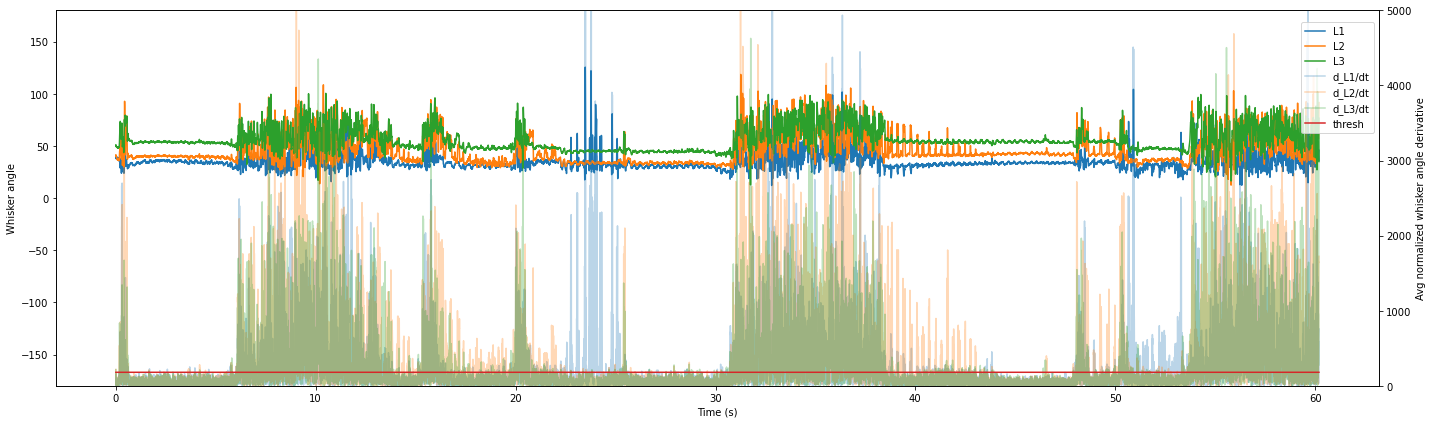

In [10]:
"""
This cell sets up and plots the left side whiskers
"""
# Plotting setup
deriv_threshold = 180 # min abs(movement) to count as moving [deg/sec]
time = np.linspace(0, len(data['L1','Angle'])/f_samp, len(data['L1','Angle'])) # Time for plotting

# Plot whisker angles and their derivs (Left only))
fig, ax1 = plt.subplots(figsize=(20,6))

# ax1.ylim((-10,10))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Whisker angle')
ax1.set_ylim([-180,180])

ax1.plot(time, data['L1','Angle'])
ax1.plot(time, data['L2','Angle'])
ax1.plot(time, data['L3','Angle'])


ax2 = ax1.twinx()
ax2.set_ylabel('Avg normalized whisker angle derivative')
ax2.set_ylim([0,5000])

ax2.plot(time, data['L1','d/dt'], alpha = 0.3)
ax2.plot(time, data['L2','d/dt'], alpha = 0.3)
ax2.plot(time, data['L3','d/dt'], alpha = 0.3)
ax2.plot(time, deriv_threshold*np.ones(len(time)))

fig.legend(['L1', 'L2', 'L3', 'd_L1/dt', 'd_L2/dt', 'd_L3/dt', 'thresh'], bbox_to_anchor=(0.96, 0.95))
fig.tight_layout()
plt.show()

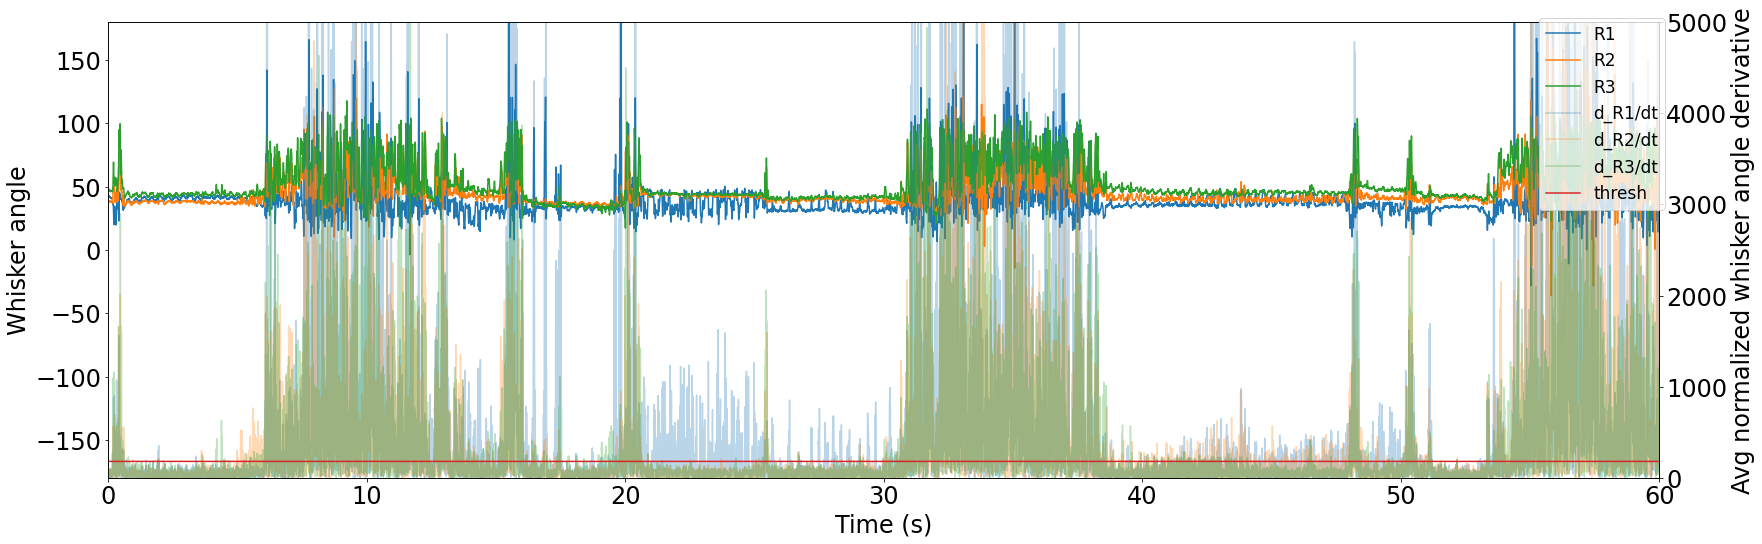

In [88]:
"""
This cell plots the right side whiskers
"""
# Plot whisker angles and their derivs (Right only))
fig, ax1 = plt.subplots(figsize=(25,8))

# ax1.ylim((-10,10))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Whisker angle')
ax1.set_ylim([-180,180])

ax1.plot(time, data['R1','Angle'])
ax1.plot(time, data['R2','Angle'])
ax1.plot(time, data['R3','Angle'])


ax2 = ax1.twinx()
ax2.set_ylabel('Avg normalized whisker angle derivative')
ax2.set_ylim([0,5000])

ax2.plot(time, data['R1','d/dt'], alpha = 0.3)
ax2.plot(time, data['R2','d/dt'], alpha = 0.3)
ax2.plot(time, data['R3','d/dt'], alpha = 0.3)
ax2.plot(time, deriv_threshold*np.ones(len(time))) 

fig.legend(['R1', 'R2', 'R3', 'd_R1/dt', 'd_R2/dt', 'd_R3/dt', 'thresh'], bbox_to_anchor=(0.94, 0.96),fontsize=17)
fig.tight_layout()
plt.xlim(0,60)
#plt.rc('legend', fontsize=14)
plt.rc('font', size=28)

plt.show()

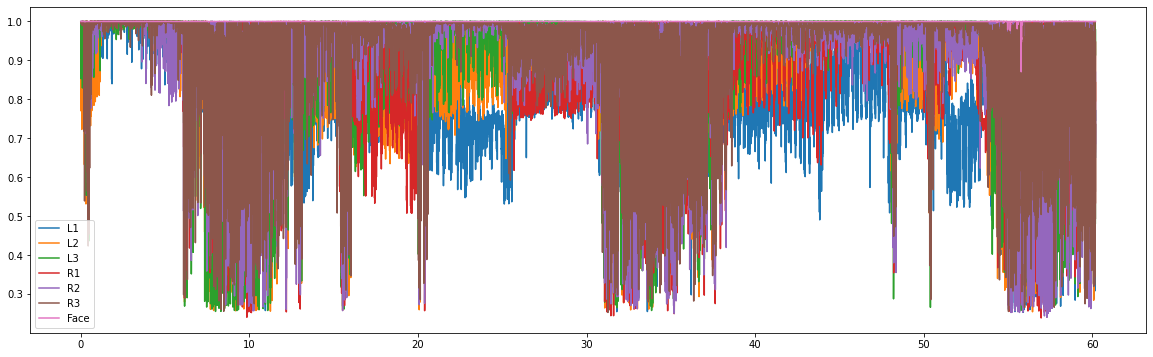

In [144]:
"""
This cell plots the calculated likelihoods
"""
# Plot whisker angle likelihoods
plt.figure(figsize=(20,6))
whiskers = ['L1', 'L2', 'L3', 'R1', 'R2', 'R3','Face']
for whisker in whiskers:
    plt.plot(time, data[whisker,'likelihood'])

plt.legend(whiskers)